In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import pearsonr
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score


STEP 1: ESTIMATE PARAMETERS OF REAL DATA

a) use the same log_likelihood function to estimate the parametrs of each dataset we collected in the experiment. Here we also run the estimation process 10 times (with different initial guess) and we take the better esimation

In [2]:
def log_likelihood_realData(parameters, file_name):
    learning_rate, intercept, slope = parameters
    Prev_p = {'midLeft': 0.25, 'midRight': 0.25, 'downLeft': 0.25, 'downRight': 0.25}
    outcomes = {}
    
    df = pd.read_csv(file_name)
    df = df[(df['epoch'] != 'practice') & (df['key_resp.rt'].notna())].copy()

    log_likelihood = 0
      
    for i in range(len(df)):
        current_targetPos = df.iloc[i]['targetPos']
        current_resp = df.iloc[i]['key_resp.corr']
        real_RT = df.iloc[i]['key_resp.rt']
        if real_RT <= 0 or pd.isna(real_RT):
            print("Not valid RT")
            continue  # salta valori non validi
        real_RS = 1 / real_RT
        
        # Compute outcomes
        for loc in Prev_p.keys():
            if current_resp == 1:
                if loc == current_targetPos:
                    outcomes[loc] = 1
                else:
                    outcomes[loc] = 0
            elif current_resp == 0:
                outcomes[loc] = 0

        #calculate RS
        predicted_RS = intercept + slope * Prev_p[current_targetPos] 
        error = real_RS - predicted_RS
        log_likelihood += -error ** 2 

        # Update probabilities
        if current_resp == 1:
            for loc in Prev_p.keys():
                Prev_p[loc] += learning_rate * (outcomes[loc] - Prev_p[loc])
                #Prev_p[loc] = min(max(Prev_p[loc], 0.0001), 0.9999)     
            total = sum(Prev_p.values())
            for loc in Prev_p.keys():
                Prev_p[loc] /= total
        elif current_resp == 0:
            continue 
            
            
    return -log_likelihood

 

In [3]:
data_dir = "C:\\Users\\cdolci\\Desktop\\Data\\SL\\"
file_pattern = os.path.join(data_dir, "*_RewSL_SL_EEG_*.csv")
#List participants
participant_files = glob.glob(file_pattern)

In [4]:
#List where I can store the estimated parametrs
participant_ids = []
estimated_learning_rate = []
estimated_intercept = []
estimated_slope = []

for file in participant_files:
    data = pd.read_csv(file)
    #extract participant's number
    if "participant" in data.columns:
        participant_id = data["participant"].iloc[0]  
    else:
        print(f"Skipping {file}: 'participant' column not found.")
        continue
    
    best_result = None
    best_log_likelihood = float('inf')
    #try the parameter estimation 10 times
    for _ in range(5):  
        random_init_params = [
            np.random.uniform(0.1, 0.9),  #Learning rate
            np.random.uniform(0.1, 10),   #Intercept
            np.random.uniform(0.1, 10)       #Slope
        ]
    
        result = minimize(log_likelihood_realData,random_init_params,args=(file,), bounds=[(0,1), (-100, 100), (-100, 100)])

        if result.success and result.fun < best_log_likelihood:
            best_log_likelihood = result.fun
            best_result = result

    #Store best results
    participant_ids.append(participant_id)

    if best_result:
        estimated_learning_rate.append(best_result.x[0])
        estimated_intercept.append(best_result.x[1])
        estimated_slope.append(best_result.x[2])
    else:
        estimated_learning_rate.append(np.nan)
        estimated_intercept.append(np.nan)
        estimated_slope.append(np.nan)
        print(f"Optimization failed for participant {participant_id}")

#Creazte DataFrame with results
results_df = pd.DataFrame({
    "Participant_ID": participant_ids,
    "Learning_Rate": estimated_learning_rate,
    "Intercept": estimated_intercept,
    "Slope": estimated_slope
})

results_df.to_csv("RealData_estimated_parameters.csv", index=False)
print("Estimation complete. Results saved in 'RealData_estimated_parameters.csv'.")

Estimation complete. Results saved in 'RealData_estimated_parameters.csv'.


STEP 3: SIMULATE RT ON REAL DATASET BY USING THE PARAMETRS WE ESTIMATED 

In [5]:
def simulate_RS(parameters, file_name): 
    learning_rate, intercept, slope = parameters
    noise_std=0.1
    Prev_p = {'midLeft': 0.25, 'midRight': 0.25, 'downLeft': 0.25, 'downRight': 0.25}
    outcomes = {}
    df = pd.read_csv(file_name)
    df = df[(df['epoch'] != 'practice') & (df['key_resp.rt'].notna())].copy()
    
    # Lists to collect trial-wise values
    simulated_RS = []
    real_RS = []
    prob_midLeft, prob_midRight, prob_downLeft, prob_downRight = [], [], [], []
    outcome_midLeft, outcome_midRight, outcome_downLeft, outcome_downRight = [], [], [], []
    prob_high, prob_lowA, prob_lowB, prob_lowC = [], [], [], []

    for i in range(len(df)):
        current_targetPos = df.iloc[i]['targetPos']
        current_resp = df.iloc[i]['key_resp.corr']
        real_RT = df.iloc[i]['key_resp.rt']
        if real_RT <= 0:
            real_RS_val = np.nan
            print("Something wrong. RT = 0")
        else:
            real_RS_val = 1 / real_RT
        real_RS.append(real_RS_val)

        #Compute outcomes
        for loc in Prev_p.keys():
            if current_resp == 1:
                if loc == current_targetPos:
                    outcomes[loc] = 1
                else:
                    outcomes[loc] = 0
            elif current_resp == 0:
                outcomes[loc] = 0

        #Store current probabilities
        prob_midLeft.append(Prev_p['midLeft'])
        prob_midRight.append(Prev_p['midRight'])
        prob_downLeft.append(Prev_p['downLeft'])
        prob_downRight.append(Prev_p['downRight'])

        #Store outcomes
        outcome_midLeft.append(outcomes['midLeft'])
        outcome_midRight.append(outcomes['midRight'])
        outcome_downLeft.append(outcomes['downLeft'])
        outcome_downRight.append(outcomes['downRight'])

        #map probability for each target frequency
        if df.iloc[i]['Slblock'] == 1:
            prob_high_val = Prev_p['midLeft']
            prob_lowA_val = Prev_p['midRight']
            prob_lowB_val = Prev_p['downLeft']
            prob_lowC_val = Prev_p['downRight'] 
        elif df.iloc[i]['Slblock'] == 2:
            prob_high_val = Prev_p['midRight']
            prob_lowA_val = Prev_p['midLeft']
            prob_lowB_val = Prev_p['downRight']
            prob_lowC_val = Prev_p['downLeft'] 
        elif df.iloc[i]['Slblock'] == 3:
            prob_high_val = Prev_p['downLeft']
            prob_lowA_val = Prev_p['downRight']
            prob_lowB_val = Prev_p['midLeft']
            prob_lowC_val = Prev_p['midRight']
        elif df.iloc[i]['Slblock'] == 4:
            prob_high_val = Prev_p['downRight']
            prob_lowA_val = Prev_p['downLeft']
            prob_lowB_val = Prev_p['midRight']
            prob_lowC_val = Prev_p['midLeft']

        #Store probabilities by frequency
        prob_high.append(prob_high_val)
        prob_lowA.append(prob_lowA_val)
        prob_lowB.append(prob_lowB_val)
        prob_lowC.append(prob_lowC_val)

        #Predict RS 
        predict_RS = intercept + slope * Prev_p[current_targetPos] + np.random.normal(0, noise_std)
        simulated_RS.append(predict_RS)

        #Update probabilities
        if current_resp == 1:
            for loc in Prev_p.keys():
                Prev_p[loc] += learning_rate * (outcomes[loc] - Prev_p[loc])
                #Prev_p[loc] = min(max(Prev_p[loc], 0.0001), 0.9999)     
            total = sum(Prev_p.values())
            for loc in Prev_p.keys():
                Prev_p[loc] /= total
        elif current_resp == 0:
            continue 
          

    # Add columns to dataframe
    df['simulated_RS'] = simulated_RS
    df['real_RS'] = real_RS

    df['prev_p_midLeft'] = prob_midLeft
    df['prev_p_midRight'] = prob_midRight
    df['prev_p_downLeft'] = prob_downLeft
    df['prev_p_downRight'] = prob_downRight

    df['outcome_midLeft'] = outcome_midLeft
    df['outcome_midRight'] = outcome_midRight
    df['outcome_downLeft'] = outcome_downLeft
    df['outcome_downRight'] = outcome_downRight

    df['prev_p_high'] = prob_high
    df['prev_p_lowA'] = prob_lowA
    df['prev_p_lowB'] = prob_lowB
    df['prev_p_lowC'] = prob_lowC

    return df

In [6]:
params_df = pd.read_csv("RealData_estimated_parameters.csv")

# Simulate for all participants
all_simulated_data = []

for file in participant_files:
    data = pd.read_csv(file)
    participant_id = data["participant"].iloc[0]

    # Get their parameters
    row = params_df[params_df["Participant_ID"] == participant_id]
    if row.empty:
        continue

    #intercept = row["Intercept"].values[0]
    #slope = row["Slope"].values[0]
    #fixed_learning_rate = 0.3
    #params = [fixed_learning_rate, intercept, slope]
    params = row[["Learning_Rate", "Intercept", "Slope"]].values.flatten()
    print(f"Participant {participant_id} - Learning Rate: {params[0]:.4f}, Intercept: {params[1]:.4f}, Slope: {params[2]:.4f}")
    simulated_df = simulate_RS(params, file)
    simulated_df['Participant_ID'] = participant_id
    all_simulated_data.append(simulated_df)

# Concatenate all
final_simulated_df = pd.concat(all_simulated_data, ignore_index=True)
final_simulated_df.to_csv("simulated_RS_all_participants.csv", index=False)

Participant 10 - Learning Rate: 0.0000, Intercept: -14.6577, Slope: 65.2747
Participant 11 - Learning Rate: 0.3701, Intercept: 1.2112, Slope: 0.2011
Participant 12 - Learning Rate: 0.0010, Intercept: 1.1483, Slope: 2.2689
Participant 1 - Learning Rate: 0.0004, Intercept: 2.3296, Slope: -1.8440
Participant 2 - Learning Rate: 0.0012, Intercept: 1.2004, Slope: 1.3154
Participant 3 - Learning Rate: 0.0000, Intercept: 26.4222, Slope: -99.6519
Participant 4 - Learning Rate: 0.0000, Intercept: 1.6501, Slope: 1.8616
Participant 5 - Learning Rate: 0.1826, Intercept: 1.0250, Slope: 0.1797
Participant 6 - Learning Rate: 0.6210, Intercept: 1.5675, Slope: 0.1078
Participant 7 - Learning Rate: 0.0003, Intercept: 1.0997, Slope: 2.7300
Participant 8 - Learning Rate: 0.0000, Intercept: 2.1033, Slope: -1.7653
Participant 9 - Learning Rate: 0.0000, Intercept: 12.7272, Slope: -44.7331


Calculate correlation and variance

In [12]:
simulated_df = pd.read_csv("simulated_RS_all_participants.csv")
participants = simulated_df['Participant_ID'].unique()

def compute_corr(df):
    r, p = pearsonr(df['real_RS'], df['simulated_RS'])
    return pd.Series({'pearson_r': r, 'p_value': p})

# Apply without including grouping column in the group data
correlations = simulated_df.groupby('Participant_ID', group_keys=False).apply(compute_corr).reset_index()

# Print results
for _, row in correlations.iterrows():
    print(f"Participant {int(row['Participant_ID'])}: r = {row['pearson_r']:.2f}, p = {row['p_value']:.4f}")

Participant 1: r = 0.05, p = 0.0773
Participant 2: r = 0.03, p = 0.2390
Participant 3: r = 0.05, p = 0.0808
Participant 4: r = -0.02, p = 0.5221
Participant 5: r = 0.10, p = 0.0009
Participant 6: r = -0.03, p = 0.3376
Participant 7: r = 0.09, p = 0.0013
Participant 8: r = -0.03, p = 0.3639
Participant 9: r = -0.03, p = 0.3639
Participant 10: r = 0.01, p = 0.6442
Participant 11: r = 0.11, p = 0.0003
Participant 12: r = 0.05, p = 0.1135


C:\Users\cdolci\AppData\Local\Temp\ipykernel_17500\1491741923.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = simulated_df.groupby('Participant_ID', group_keys=False).apply(compute_corr).reset_index()


In [7]:
simulated_df = pd.read_csv("simulated_RS_all_participants.csv")
participants = simulated_df['Participant_ID'].unique()

# Loop through each participant
for participant in participants:
    subset = simulated_df[simulated_df['Participant_ID'] == participant].copy()
    subset.reset_index(drop=True, inplace=True)

    sim_std = subset["simulated_RS"].std()
    real_std = subset["real_RS"].std()

    print(f"Participant {participant} → Simulated RS std: {sim_std:.4f}, Real RS std: {real_std:.4f}")

Participant 10 → Simulated RS std: 0.1036, Real RS std: 0.2961
Participant 11 → Simulated RS std: 0.1178, Real RS std: 0.2775
Participant 12 → Simulated RS std: 0.1081, Real RS std: 0.2713
Participant 1 → Simulated RS std: 0.1011, Real RS std: 0.2689
Participant 2 → Simulated RS std: 0.1027, Real RS std: 0.2808
Participant 3 → Simulated RS std: 0.1117, Real RS std: 0.3181
Participant 4 → Simulated RS std: 0.0954, Real RS std: 0.3493
Participant 5 → Simulated RS std: 0.1097, Real RS std: 0.1988
Participant 6 → Simulated RS std: 0.1043, Real RS std: 0.3391
Participant 7 → Simulated RS std: 0.1021, Real RS std: 0.3346
Participant 8 → Simulated RS std: 0.1024, Real RS std: 0.3144
Participant 9 → Simulated RS std: 0.0992, Real RS std: 0.2535


b) plot the real vs simulated RT to see if they were well simulated

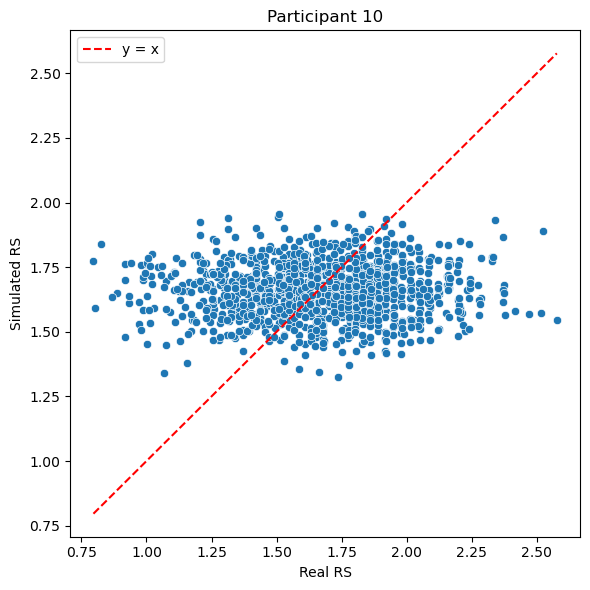

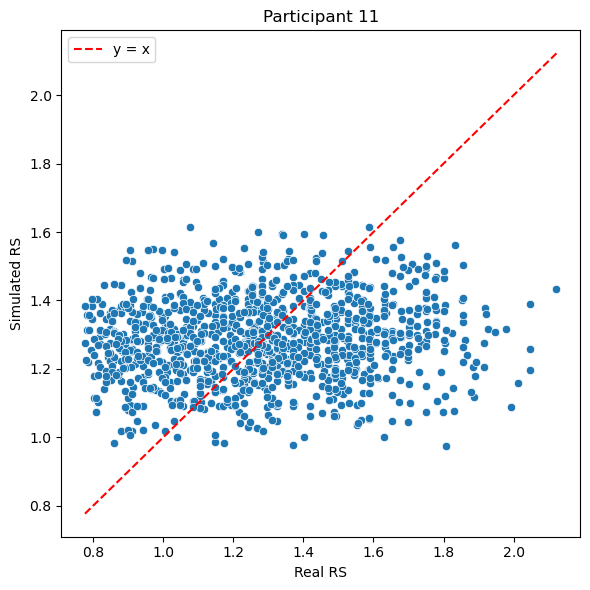

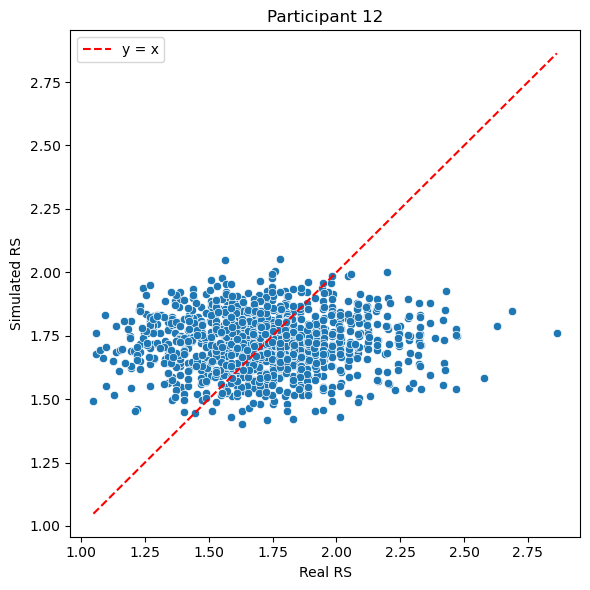

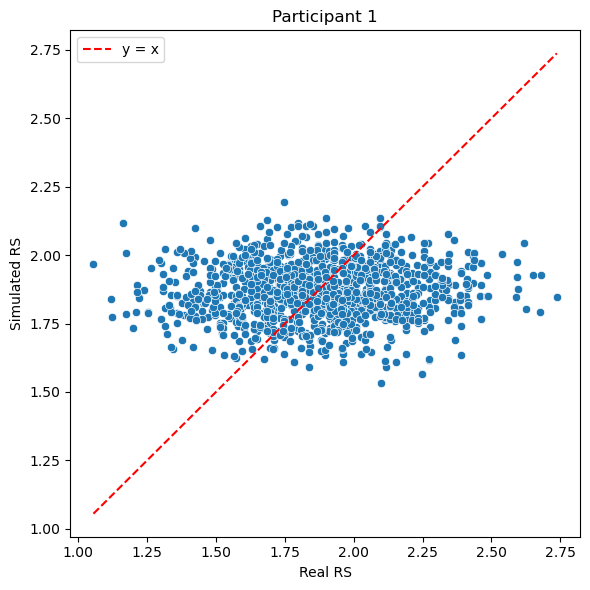

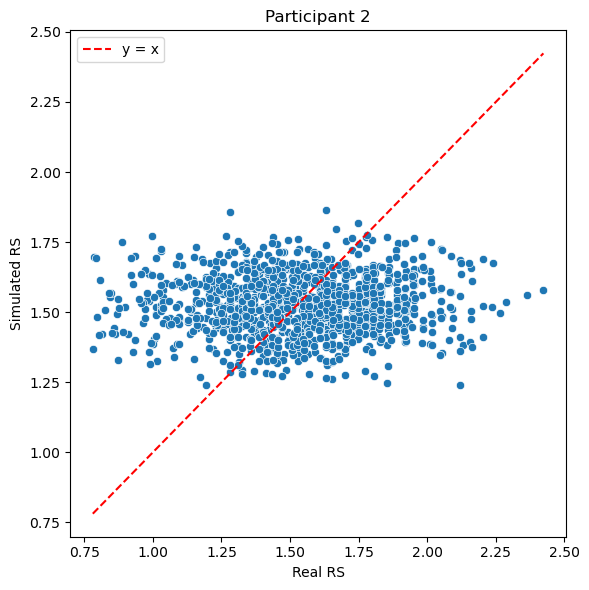

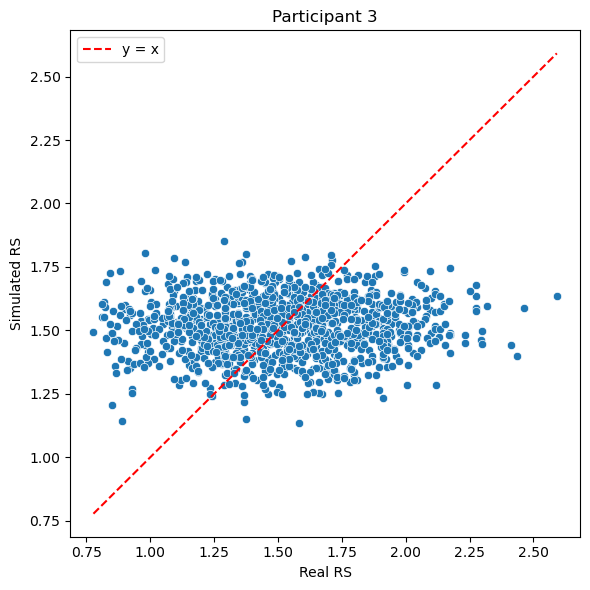

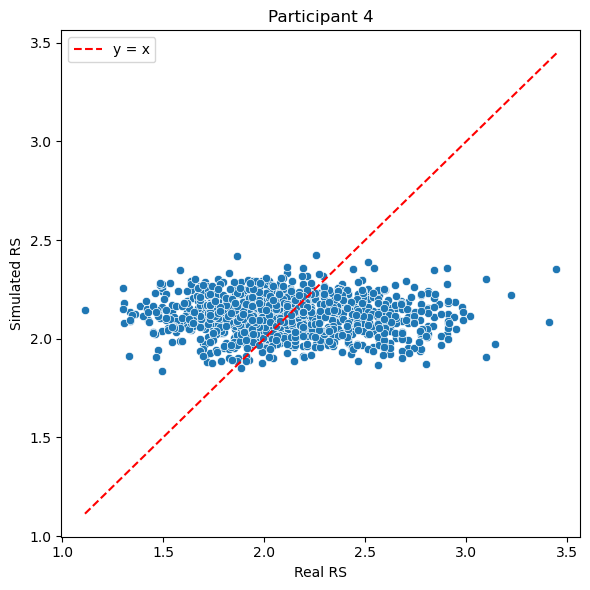

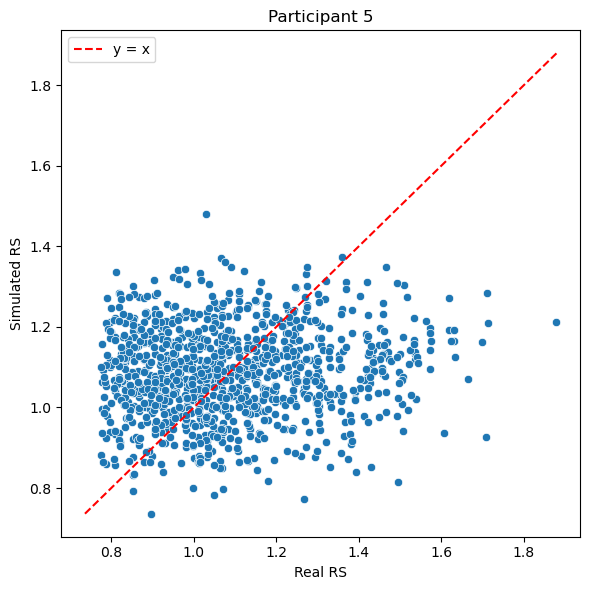

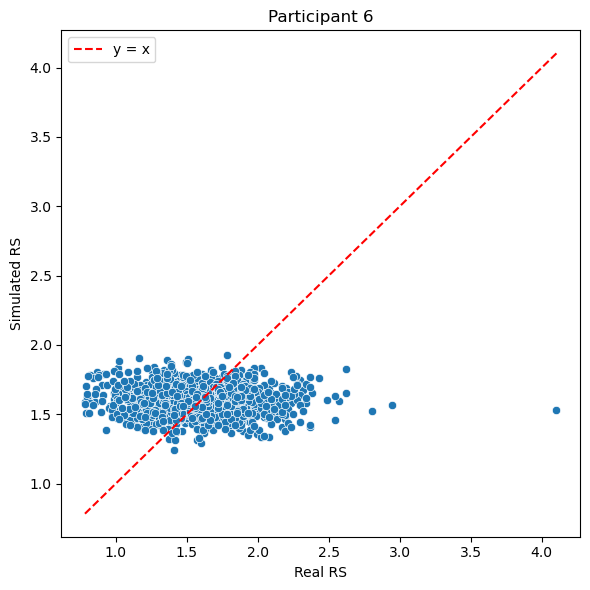

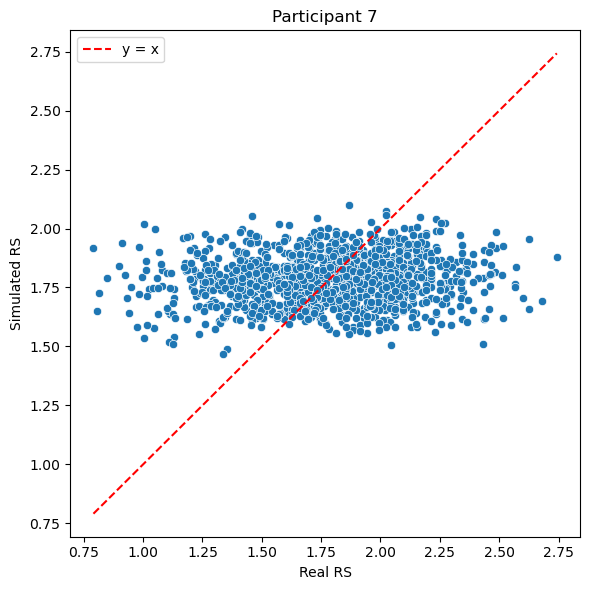

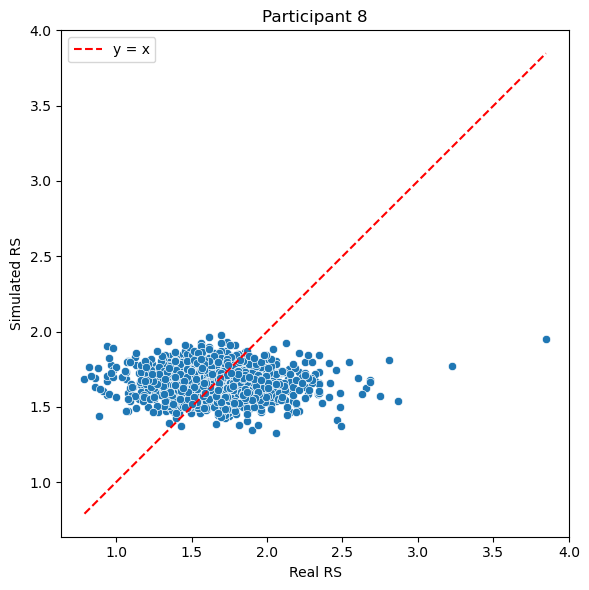

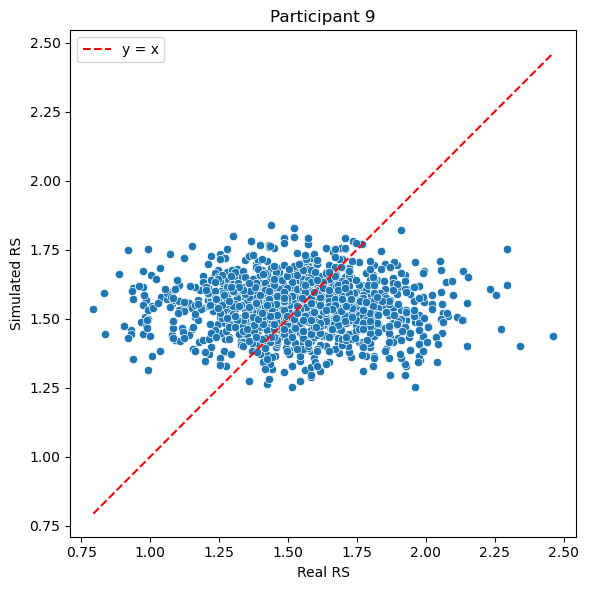

In [9]:
simulated_df = pd.read_csv("simulated_RS_all_participants.csv")
participants = simulated_df['Participant_ID'].unique()

# Loop through each participant
for participant in participants:
    subset = simulated_df[simulated_df['Participant_ID'] == participant].copy()
    subset.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=subset, x='real_RS', y='simulated_RS')

    # Diagonal reference line (y = x)
    min_val = min(subset['real_RS'].min(), subset['simulated_RS'].min())
    max_val = max(subset['real_RS'].max(), subset['simulated_RS'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel('Real RS')
    plt.ylabel('Simulated RS')
    plt.title(f'Participant {participant}')
    plt.legend()
    plt.tight_layout()
    plt.show()

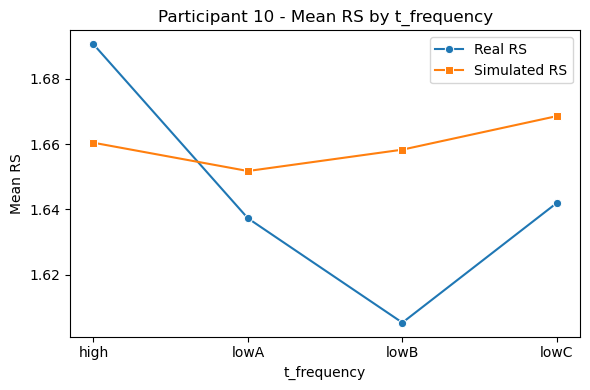

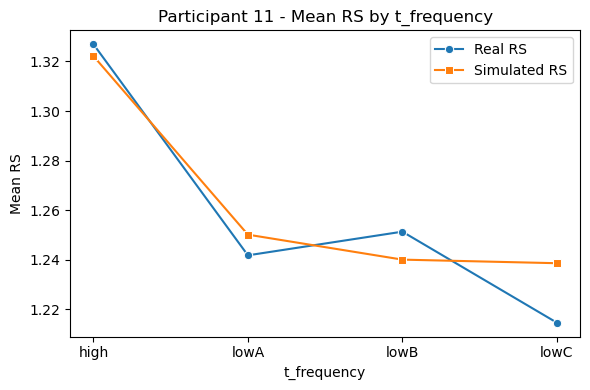

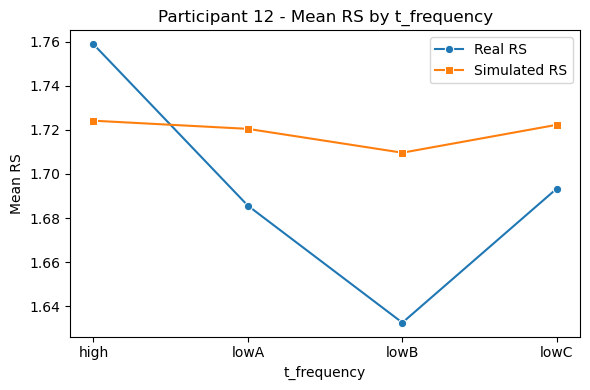

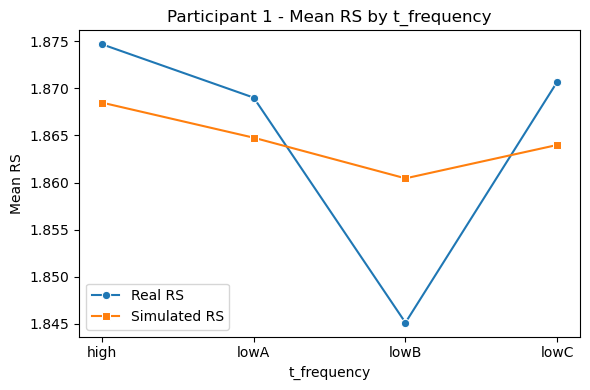

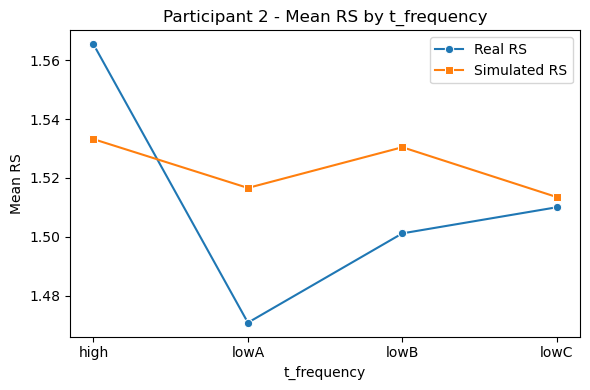

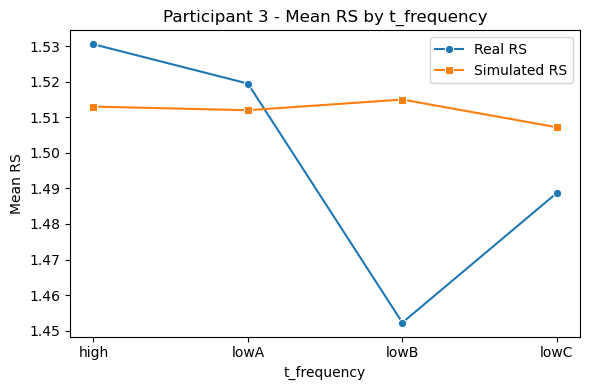

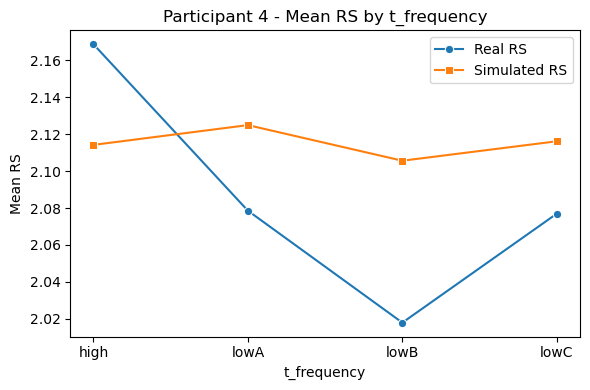

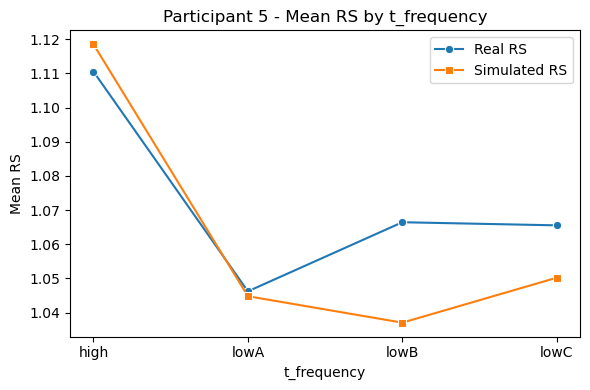

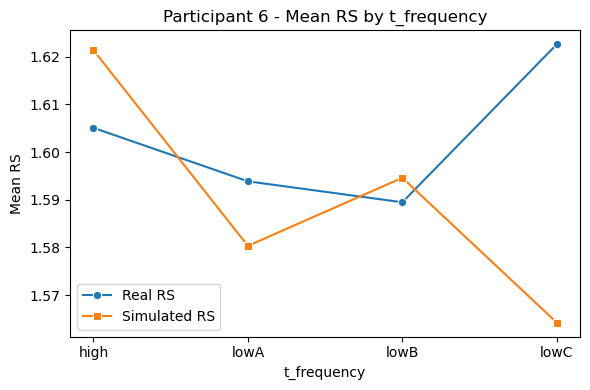

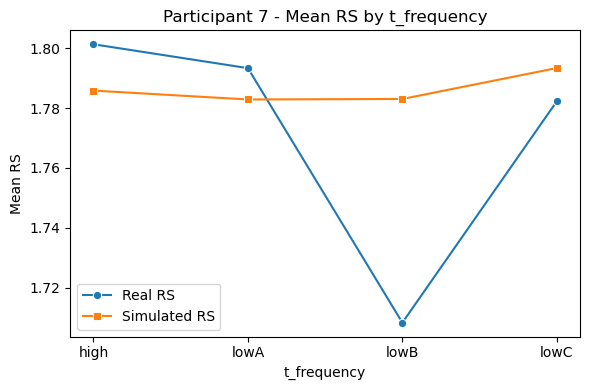

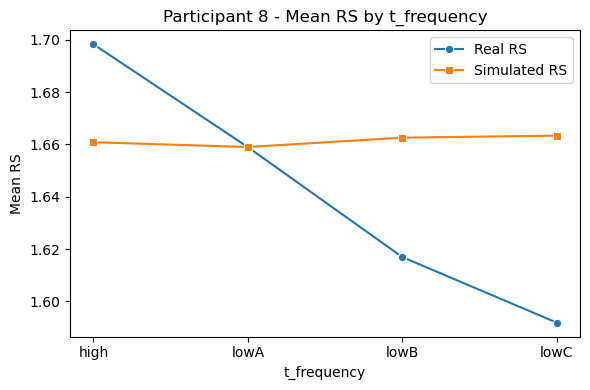

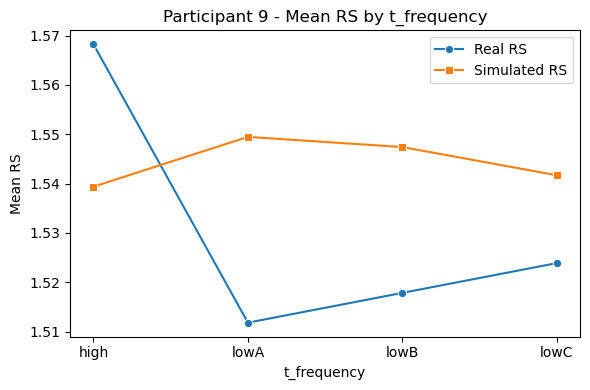

In [11]:
simulated_df = simulated_df.dropna(subset=['real_RS'])

# Get unique participant IDs
participants = simulated_df['Participant_ID'].unique()

# Loop through each participant
for participant in participants:
    # Filter data for the current participant
    subset = simulated_df[simulated_df['Participant_ID'] == participant]
    
    # Group by condition and compute mean RS values
    mean_rts = subset.groupby('t_frequency').agg(
        real_RS=('real_RS', 'mean'),
        simulated_RS=('simulated_RS', 'mean')
    ).reset_index()
    
    # Plot
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=mean_rts, x='t_frequency', y='real_RS', label='Real RS', marker='o')
    sns.lineplot(data=mean_rts, x='t_frequency', y='simulated_RS', label='Simulated RS', marker='s')
    
    plt.title(f'Participant {participant} - Mean RS by t_frequency')
    plt.xlabel('t_frequency')
    plt.ylabel('Mean RS')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
simulated_df = pd.read_csv("simulated_RS_all_participants.csv")
participants = simulated_df['Participant_ID'].unique()

#Loop through each participant
for participant in participants:
    subset = simulated_df[simulated_df['Participant_ID'] == participant].copy()

    #Group by trial number within block and compute means
    grouped = subset.groupby('trials_e.thisN')[['real_RS', 'simulated_RS']].mean().reset_index()

    #Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=grouped, x='real_RS', y='simulated_RS')

    # Diagonal reference line (y = x)
    min_val = min(grouped['real_RS'].min(), grouped['simulated_RS'].min())
    max_val = max(grouped['real_RS'].max(), grouped['simulated_RS'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel('Mean Real RS (per trial index)')
    plt.ylabel('Mean Simulated RS (per trial index)')
    plt.title(f'Participant {participant}')
    plt.legend()
    plt.tight_layout()
    plt.show()